In [12]:
!pip install tune_sklearn

     -------------------------------------- 41.1/41.1 KB 282.9 kB/s eta 0:00:00
     -------------------------------------- 21.1/21.1 MB 153.3 kB/s eta 0:00:00
     ---------------------------------------- 8.8/8.8 MB 120.7 kB/s eta 0:00:00
     ------------------------------------ 125.4/125.4 KB 133.9 kB/s eta 0:00:00
     ------------------------------------ 468.5/468.5 KB 284.8 kB/s eta 0:00:00


You should consider upgrading via the 'C:\Games\conda\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: filelock
    Found existing installation: filelock 3.3.1
    Uninstalling filelock-3.3.1:
      Successfully uninstalled filelock-3.3.1


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import nan
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import copy
from tune_sklearn import TuneSearchCV
import scipy
from ray import tune
from sklearn.metrics import completeness_score

In [2]:
df = pd.read_csv(r"C:\Users\Darya\archive (1)\train_loan\train.csv")

In [3]:
df

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
1,APPD40611263344,Male,07/12/86,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
2,APPE70289249423,Male,10/12/82,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0
3,APPF80273865537,Male,30/01/89,09/07/16,C10477,C,COM0004143,A,4.0,3500.0,...,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0
4,APPG60994436641,Male,19/04/85,20/07/16,C10002,A,COM0001781,A,4.0,10000.0,...,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,31/07/83,30/09/16,C10006,A,COM0000010,A,1.0,4900.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,10,0
69709,APPV80989824738,Female,27/01/71,30/09/16,C10116,C,COM0045789,A,4.0,7190.1,...,N,S122,G,1450.0,NaN,NaN,NaN,NaN,7,0
69710,APPW50697209842,Female,01/02/92,30/09/16,C10022,B,COM0013284,C,4.0,1600.0,...,Y,S122,G,0.0,24000.0,4.0,35.50,943.0,2,0
69711,APPY50870035036,Male,27/06/78,30/09/16,C10002,A,COM0000098,C,3.0,9893.0,...,Y,S122,G,1366.0,80000.0,5.0,NaN,NaN,10,0


In [4]:
def data_preprocessing(df):

    df.loc[(df['Gender'] == 'Female'), 'Gender'] = 0
    df.loc[(df['Gender'] != 0), 'Gender'] = 1
    # добавим признак возраст
    df['DOB_year'] = nan
    df.loc[df['DOB'].notnull(), 'DOB_year'] = 121 - df['DOB'].loc[df['DOB'].notnull()].str[-2:].astype(int)
    df['DOB_year'] = df['DOB_year'].fillna(df['DOB_year'].median())
    # добавим признак дней с начала года от даты заёма (в данных июль-сентябрь 2016)
    df['Lead_Creation_Date'] = df['Lead_Creation_Date'].str.replace(r'(..\/..\/)(..)', r'\1 20\2')
    df['Lead_Creation_Date'] = pd.to_datetime(df['Lead_Creation_Date'], format="%d/%m/ %Y")
    df['Lead_Creation_Date_day'] = (df['Lead_Creation_Date']-pd.to_datetime('1/1/2016')).astype('timedelta64[h]')/24

    #удаляем первый символ данных столбцов (они одинаковы), преобразуем в int,
    #заменяем nan на моду (признак был категориальным)
    first_drop_cols = ['City_Code', 'Source', 'Customer_Existing_Primary_Bank_Code']
    for i in first_drop_cols:
        df[i] = df[i].loc[df[i].notnull()].str[1:].astype(int)
        df[i] = df[i].fillna(df[i].mode()[0])
    # удаляем первые 3 символа и далее аналогично верхнему
    df['Employer_Code'] = df['Employer_Code'].loc[df['Employer_Code'].notnull()].str[3:].astype(int)
    df['Employer_Code'] = df['Employer_Code'].fillna(df['Employer_Code'].mode()[0])
    # заполняем nan медианой
    amount_cols = ['Employer_Category2', 'Monthly_Income', 'Existing_EMI', 'Loan_Amount','Loan_Period', 'Interest_Rate', 'EMI', 'Var1'] 
    df[amount_cols] = df[amount_cols].fillna(df[amount_cols].median())
    # заполняем nan модой и кодируем столбцы (переводим в численные)
    str_cols = ['City_Category', 'Employer_Category1', 'Primary_Bank_Type', 'Contacted', 'Source_Category']
    str_dict = dict(enumerate(str_cols))
    for i in str_cols:
        df[i] = df[i].fillna(df[i].mode()[0])
    le = LabelEncoder()
    df[str_cols] = df[str_cols].apply(le.fit_transform)
    return df

In [5]:
df = data_preprocessing(df)
df

C:\Users\Darya\AppData\Local\Temp/ipykernel_15608/4215930945.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Lead_Creation_Date'] = df['Lead_Creation_Date'].str.replace(r'(..\/..\/)(..)', r'\1 20\2')


,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,DOB_year,Lead_Creation_Date_day
0,APPC90493171225,0,23/07/79,2016-07-15,10001.0,0,44082.0,0,4.0,2000.0,...,6,0.0,30000.0,4.0,18.00,941.0,0,0,42.0,196.0
1,APPD40611263344,1,07/12/86,2016-07-04,10003.0,0,2.0,2,1.0,3500.0,...,6,0.0,20000.0,2.0,13.25,953.0,10,0,35.0,185.0
2,APPE70289249423,1,10/12/82,2016-07-19,10125.0,2,5267.0,2,4.0,2250.0,...,1,0.0,45000.0,4.0,18.00,941.0,0,0,39.0,200.0
3,APPF80273865537,1,30/01/89,2016-07-09,10477.0,2,4143.0,0,4.0,3500.0,...,1,0.0,92000.0,5.0,18.00,941.0,7,0,32.0,190.0
4,APPG60994436641,1,19/04/85,2016-07-20,10002.0,0,1781.0,0,4.0,10000.0,...,1,2500.0,50000.0,2.0,18.00,941.0,10,0,36.0,201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,0,31/07/83,2016-09-30,10006.0,0,10.0,0,1.0,4900.0,...,6,0.0,30000.0,4.0,18.00,941.0,10,0,38.0,273.0
69709,APPV80989824738,0,27/01/71,2016-09-30,10116.0,2,45789.0,0,4.0,7190.1,...,6,1450.0,30000.0,4.0,18.00,941.0,7,0,50.0,273.0
69710,APPW50697209842,0,01/02/92,2016-09-30,10022.0,1,13284.0,2,4.0,1600.0,...,6,0.0,24000.0,4.0,35.50,943.0,2,0,29.0,273.0
69711,APPY50870035036,1,27/06/78,2016-09-30,10002.0,0,98.0,2,3.0,9893.0,...,6,1366.0,80000.0,5.0,18.00,941.0,10,0,43.0,273.0


In [6]:
not_float_cols = ['ID', 'DOB', 'Lead_Creation_Date']
df[df.columns.difference(not_float_cols)] = df[df.columns.difference(not_float_cols)].astype(float)

In [7]:
df = df[df.columns.difference(not_float_cols)]
df

,Approved,City_Category,City_Code,Contacted,Customer_Existing_Primary_Bank_Code,DOB_year,EMI,Employer_Category1,Employer_Category2,Employer_Code,...,Gender,Interest_Rate,Lead_Creation_Date_day,Loan_Amount,Loan_Period,Monthly_Income,Primary_Bank_Type,Source,Source_Category,Var1
0,0.0,0.0,10001.0,0.0,1.0,42.0,941.0,0.0,4.0,44082.0,...,0.0,18.00,196.0,30000.0,4.0,2000.0,1.0,122.0,6.0,0.0
1,0.0,0.0,10003.0,1.0,2.0,35.0,953.0,2.0,1.0,2.0,...,1.0,13.25,185.0,20000.0,2.0,3500.0,1.0,122.0,6.0,10.0
2,0.0,2.0,10125.0,1.0,3.0,39.0,941.0,2.0,4.0,5267.0,...,1.0,18.00,200.0,45000.0,4.0,2250.0,0.0,143.0,1.0,0.0
3,0.0,2.0,10477.0,1.0,3.0,32.0,941.0,0.0,4.0,4143.0,...,1.0,18.00,190.0,92000.0,5.0,3500.0,0.0,143.0,1.0,7.0
4,0.0,0.0,10002.0,1.0,1.0,36.0,941.0,0.0,4.0,1781.0,...,1.0,18.00,201.0,50000.0,2.0,10000.0,1.0,134.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,0.0,0.0,10006.0,0.0,2.0,38.0,941.0,0.0,1.0,10.0,...,0.0,18.00,273.0,30000.0,4.0,4900.0,1.0,122.0,6.0,10.0
69709,0.0,2.0,10116.0,0.0,2.0,50.0,941.0,0.0,4.0,45789.0,...,0.0,18.00,273.0,30000.0,4.0,7190.1,1.0,122.0,6.0,7.0
69710,0.0,1.0,10022.0,1.0,30.0,29.0,943.0,2.0,4.0,13284.0,...,0.0,35.50,273.0,24000.0,4.0,1600.0,1.0,122.0,6.0,2.0
69711,0.0,0.0,10002.0,1.0,2.0,43.0,941.0,2.0,3.0,98.0,...,1.0,18.00,273.0,80000.0,5.0,9893.0,1.0,122.0,6.0,10.0


In [8]:
X = df.drop(['Approved'], axis = 1)
y = df['Approved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [10]:
y_pred = clf.predict(X_test)

print(precision_recall_fscore_support(y_test, y_pred))
print(roc_auc_score(y_test, y_pred, average='weighted'))

(array([0.98619243, 0.05023923]), array([0.98073751, 0.06907895]), array([0.9834574 , 0.05817175]), array([20610,   304], dtype=int64))
0.524908226716719


In [11]:
print(completeness_score(y_test, y_pred))

0.0057479405076410915


In [12]:
recall_score(y_test, y_pred, pos_label=0)

0.980737506065017

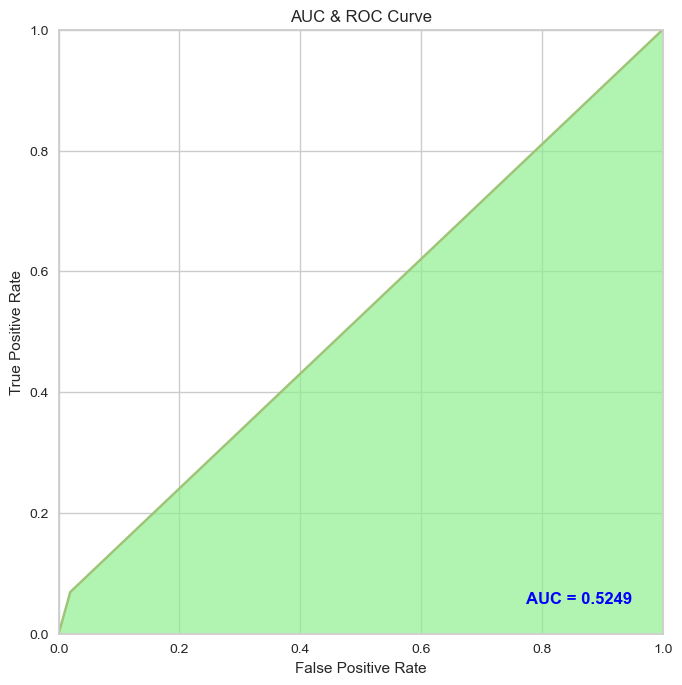

In [17]:
import sklearn.metrics as metrics

y_pred = clf.predict(X_test)
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [16]:
!pip install yellowbrick --user

You should consider upgrading via the 'C:\Games\conda\python.exe -m pip install --upgrade pip' command.


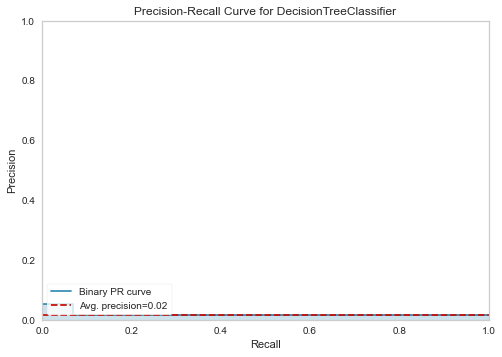

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [14]:
import yellowbrick
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.linear_model import LogisticRegression

viz = PrecisionRecallCurve(tree.DecisionTreeClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

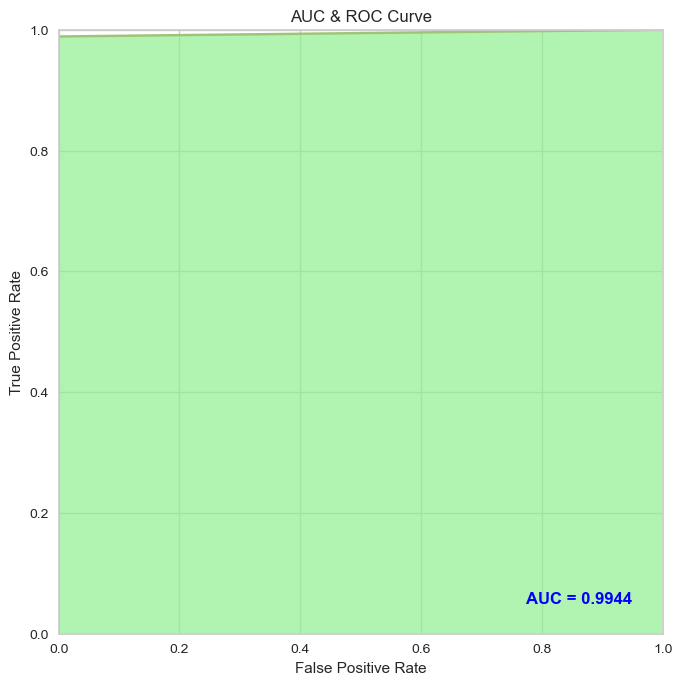

In [18]:
y_pred1 = y_pred = clf.predict(X_train)
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_train, y_pred1)
auc = roc_auc_score(y_train, y_pred1)
plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

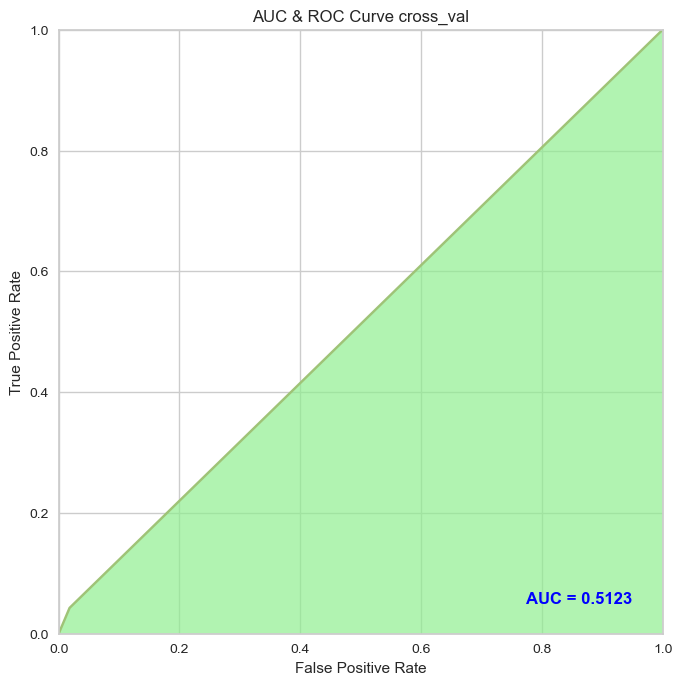

In [21]:
from sklearn.model_selection import cross_val_predict

y_pred2 = cross_val_predict(clf, X_test, y_test, cv=3)
false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_pred2)
auc = roc_auc_score(y_test, y_pred2)
plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve cross_val")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
y_clf = clf.predict(X_test)

In [25]:
from sklearn.ensemble import AdaBoostClassifier

clf1 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf1.fit(X_train, y_train)
y_clf1 = clf1.predict(X_test)

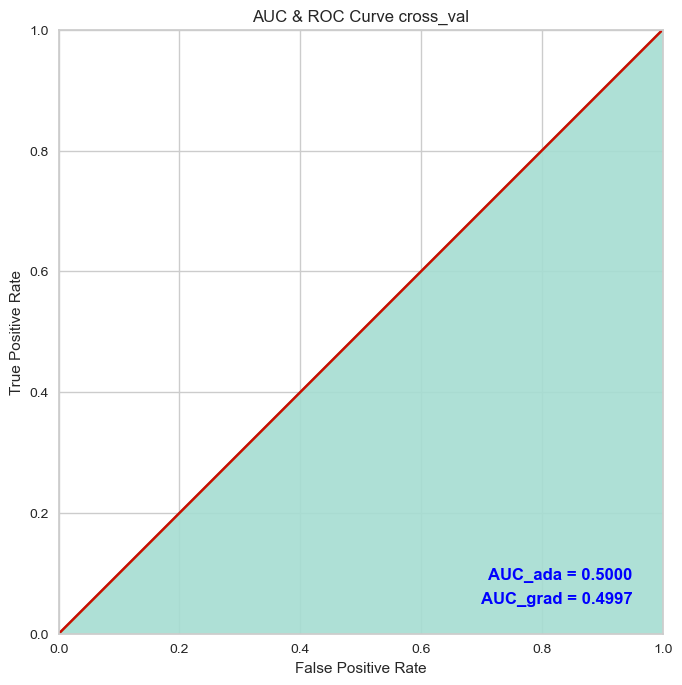

In [26]:
false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_clf)
false_positive_rate1, true_positive_rate1, thresolds1 = roc_curve(y_test, y_clf1)
auc = roc_auc_score(y_test, y_clf)
auc1 = roc_auc_score(y_test, y_clf1)
plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve cross_val")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.plot(false_positive_rate1, true_positive_rate1, 'r')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.fill_between(false_positive_rate1, true_positive_rate1, facecolor='lightblue', alpha=0.7)
plt.text(0.95, 0.05, 'AUC_grad = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.text(0.95, 0.09, 'AUC_ada = %0.4f' % auc1, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()